# Value Lost

A notebook to determine the value lost when applying a maintenance strategy defined in an asset model to the population with an explanation of the steps to gee there.

Requested: greg.bell@essentialenergy.com.au
Author: gavin.treseder@essentialenergy.com.au

## Contents
1. Project Setup
2. Load Data
3. Simulation
4. Sensitivity


## Project Setup
Several steps need to be completed to get the project ready for analysis:
- Import packages: Import the packages that are required for this process 
- Current Working Directory: Set the file path so that we can import pof code and load files

In [1]:
import copy
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from IPython.display import clear_output
import numpy as np 
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as ss

from pof.system import System
from pof.interface.figures import make_sensitivity_fig, make_value_lost_fig, make_contour_plot
from pof.loader.asset_model_loader import AssetModelLoader
from pof.paths import Paths

%matplotlib inline

# Load Data
## Load the Asset Model
The asset model needs to be loaded from the excel file and converted into a component object that execute simulations

In [76]:
asset_model_filename = "Asset Model.xlsx"

paths = Paths()
model_path = paths.demo_path + os.sep + asset_model_filename

try:
    aml = AssetModelLoader()
    pof_data = aml.load(model_path)
    system = System.from_dict(pof_data['overhead_network'])
    comp = system.comp['pole']
    print("Asset Model loaded")
    pass
except:
    comp = Component.demo()
    print("Demo Model loaded")

Asset Model loaded


### Simulation - Single Event
See Failure Mode notebook

### Simulation - Monte Carlo 
The purpose of sensitivity is to understand the relationship between cost/risk/performance of a maintainence strategy when an input variable is changed. In previous notebooks we introduced the simulation concept and the outputs that can be produced. The length of time required to complete a sensitivity analysis is influenced by:
- t_end: the length of the time the each iteration is simulated to (sim time increases with t_end. Dependent on expected life and whether replacements occur)
- n_iterations: the number of iterations that are completed per simulation (sim time increases with n_iterations)
- model_units: the time units to use when completing a simmulation (sim time increases with smaller units)
The simulation is below has been set to complete quickly to demonstrate functionality

In [3]:
t_end = 100
n_iterations = 100
model_units = 'years'

In [4]:
comp.units = model_units
comp.mc_timeline(t_end=t_end, n_iterations=n_iterations)
comp.expected_risk_cost_df()
comp.plot_ms()

### Sensitivity
The purpose of sensitivity is to understand the relationship between cost/risk/performance of a maintainence strategy when an input variable is changed. It is influence by the following parameters
- var_id: the variable id for which sensitivity is going to be adjusted.
- lower: the lower limit for the var_id
- upper: the upper limit for the var_id
- step_size: the size of the increments that are going to be used
The length of time required to complete a sensitivity analysis is influenced by t_end, n_iterations and model_units. The simulation is below has been set to complete quickly to demonstrate functionality.

In [5]:
var_id = 'pole-task_group_name-groundline-t_interval'
lower = 0
upper = 10 
step_size = 1

In [6]:
comp.expected_sensitivity(var_id, lower, upper, step_size, n_iterations, t_end)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

In [8]:
comp.df_sens.to_csv(paths.output_path + os.sep + f"sens_{var_id}_{lower}-{upper}-{step_size}.csv")

In [ ]:
comp.calc_df_task_forecast(sfd.df_age_forecast)

## Determine Parameters that have the greatest impact
Considering the impact of all sensitivities at the same time results in a large computational burden. Considering the sensitivity of each parameters in isolation first allows parameters that have limited impact to be ignored and the focus shifted to high impact parameters.


In [9]:
#TODO update illyses code
# conf = 0.9
# n_increments = 10
# n_iterations = 100

# #if it's even add one
# df_sens = comp.sensitivity(var_name = df_inspection_slow, conf =  conf, n_increments = n_increments, n_iterations = n_iterations)

# comp.make_sensitivity_plot(
#     data = df_sens,
#     x_axis = 'conf',
#     y_axis = 'var_name',
#     failure_mode = 'slow_aging',
#     plot_type = 'heatmap',
#     z_axis = 'risk_cost',
# )

## Investigate the relationship between multiple parameters

There are often situations where the relationship between multiple parameters need to be considered at the same time. Creating a sesnitivity chain becomes computationally expensive so should only be considered for parameters that have a known impact.

- sens_vars: A dictionary of variables to chain with a list of values to evaluate.

The lists can be generated using three methods:
- [list][1]: a list of values to use
- [np.arange][2]: a list of numbers between *start* and *stop* at every *step* 
- [np.linspace][3]: a list of numbers between *start* and *stop* broken up into *num* increments

These three methods are equivalent:
~~~ python
sens_vars = {
    'var_list' : [0, 2, 4, 6, 8, 10],
    'var_arange' : np.arange(start = 0, stop = 11, step = 2), #parameter names are optional
    'var_linspace' : np.linspace(start = 0, stop = 10, num = 6) #parameter names are optional
}
~~~
[1]: https://docs.python.org/3/tutorial/datastructures.html
[2]: https://numpy.org/doc/stable/reference/generated/numpy.arange.html
[3]: https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace

In [49]:
sens_vars = {
    'pole-consequence-cost': np.concatenate([np.arange(2e4, 1e5,2e4), np.arange(1e5,6e5,1e5)]),
    'pole-task_group_name-groundline-t_interval': np.arange(0, 10, 1),
}
sens_vars

{'pole-consequence-cost': array([ 20000.,  40000.,  60000.,  80000., 100000., 200000., 300000.,
        400000., 500000.]),
 'pole-task_group_name-groundline-t_interval': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [50]:
df_sens_chain = comp.sensitivty_chain(sens_vars, t_end=t_end, n_iterations=n_iterations)
df_sens_chain.head()

,task,active,quantity,quantity_annual,quantity_cumulative,quantity_lifecycle,cost,cost_annual,cost_cumulative,cost_lifecycle,pole-task_group_name-groundline-t_interval,pole-consequence-cost
0,risk,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20000.0
1,risk,True,0.01,0.000128,0.03,0.000383,200.0,2.551346,600.0,7.654038,0,20000.0
2,conditional_failure,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20000.0
3,conditional_failure,True,0.02,0.000255,0.25,0.003189,70.0,0.892971,875.0,11.162138,0,20000.0
4,functional_failure,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20000.0


In [ ]:
df_sens_chain.to_csv(paths.output_path + os.sep + f"sens_chain.csv")

### Rolling mean
Increasing the number of iterations to reduce the 'spikeiness' of the sensitivity charts is not always feasabily. To reduce simulation times, it can be beneficial to use a rolling mean to smooth out the profile and more easily identify trends, minimums or maximums.

In [51]:
x_var = var_id
y_var = 'pole-consequence-cost'
window=5

In [52]:
def rolling_mean(df, x_var:str, y_var:str, window=5):
    """ Returns a df with a rolling mean"""
    #TODO set this up so it work for
    #TODO move this to expected_cost

    df_rolling = (
        df.copy(deep=True)
        .rename(columns={'task':'source'})
        .dropna()
        .sort_values(by=['source', x_axis, y_var])
    )

    # Reduce the window size if not enough values are passed
    window = max(0,min(len(df_rolling[y_var].unique()) - 1, window))

    # Generate a rolling average
    df_rolling = df_rolling.groupby(by=['source', y_axis]).rolling(5).mean().drop([y_var], axis=1).reset_index().dropna()

    df_rolling['active'] = df_rolling['active'].astype(bool)

    return df_rolling


In [53]:
# Apply the function
df_rolling = rolling_mean(df_sens_chain, x_var=x_var, y_var=y_var,window=window)

# Create df_plot for generating a figure
df_plot = df_rolling.loc[df_rolling[y_var] == df_rolling.iloc[-1][y_var]]
df_plot.rename(columns={x_var : x_var.split('-')[-1]}, inplace=True)
make_sensitivity_fig(df_plot, var_name=x_var, y_axis = 'cost_cumulative')

In [54]:
def calc_value_lost(df, x_var:str, y_var:str, z_var='cost_cumulative'):
    """ Takes a df of risk costs and returns a df with teh value lost
    # TODO move this to risk cost
    # TODO check y_var and x_var are the right way around
    """

    prefix = ["quantity", "cost"]
    suffix = ["_cumulative", '_lifecycle']
    cols = [f"{pre}{suf}" for pre in prefix for suf in suffix]

    # Calculate the total cost for each scenario
    df = df_rolling.groupby(by=[x_var, y_var])[cols].sum()

    # Calculate the value_lost at each interval
    df['value_lost'] = df[z_var] - df.groupby(by=[y_var])[z_var].transform('min') 

    return df.reset_index()

In [55]:
df_total = calc_value_lost(df=df_rolling, x_var='pole-task_group_name-groundline-t_interval', y_var='pole-consequence-cost', z_var='cost_lifecycle')

# Plot the results to check it works 
px.line(df_total.reset_index(), x='pole-task_group_name-groundline-t_interval', y = 'value_lost', color='pole-consequence-cost')

In [56]:
x_axis = 'pole-task_group_name-groundline-t_interval'
y_axis = 'pole-consequence-cost'
z_axis = 'value_lost'

make_contour_plot(df_total, x_axis=x_axis, y_axis=y_axis, z_axis=z_axis)

# Match Asset Models to the population
## Load the population data
The population data needs to be loaded with all the asset information that has been used to differentiate models

In [57]:
filename = "ACS - Poles - Consequence Model Output.csv"
print("File Loading...")
df_cons = pd.read_csv(paths.csv_path + os.sep + filename)
clear_output()
df_cons.head()

,Unnamed: 0,ASSET_ID,Depot (ZSG Area),Pole_LU_NSWMajo,Pole_LU_NSWDeta,Pole_LU_ALUMMaj,Pole_LU_ALUMDet,Road Crossing Conductor Type,HV_LV Status,BushfirePriority,...,C_Environment_Rank,Site_Bushfire_Moderate_Probability,Site_Bushfire_Severe_Probability,C_Bushfire_Dollars,Site_Environment_Insignificant_Probability,Site_Environment_Minor_Probability,C_Environment_Dollars,C_Financial_Dollars,Total Consequence $,Radial(Y/N)
0,0,388,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2802.19134,21198.144867,NaN
1,1,389,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2802.57978,21198.533307,NaN
2,2,390,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2803.09692,21199.050447,NaN
3,3,391,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2803.76382,21199.717347,NaN
4,4,392,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2804.33010,21200.283627,NaN


## Match to the closest model
Each asset needs to be matched with the model that most closely represents it's parameters. This requires transforming the columns to align with the 

In [58]:
# TODO turn ino a function so it works for mutliple y vars
pop_var = 'Total Consequence $'
sens_var = 'pole-consequence-cost'
df_sens_var = pd.DataFrame(sens_vars[sens_var], columns= [sens_var])

# Fill with average val
df_cons[pop_var] = df_cons[pop_var].fillna(df_cons[pop_var].mean())

# Match to the closest value from the model
df = pd.merge_asof(
    df_cons.sort_values(pop_var),
    df_sens_var,
    left_on = pop_var,
    right_on = sens_var,
    direction = 'forward'
)

## Remove uncessary columns
Computational time can be increased by removing information that isn't needed

In [59]:
#TODO generalise to work for any columns
uid_col = 'ASSET_ID'
agg_cols = ['Depot (ZSG Area)']
interesting_cols = []
col_to_keep = [uid_col] + agg_cols + [pop_var] + [sens_var] + interesting_cols

df = df[col_to_keep]
df.head()

,ASSET_ID,Depot (ZSG Area),Total Consequence $,pole-consequence-cost
0,2766284,Warialda Depot,4460.79550,20000.0
1,2706503,Warialda Depot,4461.16756,20000.0
2,2565300,Texas Depot,4461.29392,20000.0
3,2564350,Texas Depot,4461.37816,20000.0
4,2566388,Texas Depot,4461.51388,20000.0


### Count assets within each subpopluation
To speed up execution the code, the number of assets within each group can be combined 

In [60]:
by = agg_cols + [sens_var]
df_pop = df.groupby(by=by)[uid_col].count().reset_index().rename(columns={uid_col:'asset_count'})
df_pop.head()

,Depot (ZSG Area),pole-consequence-cost,asset_count
0,Albury Depot,20000.0,7506
1,Albury Depot,40000.0,5195
2,Albury Depot,60000.0,113
3,Albury Depot,80000.0,385
4,Albury Depot,100000.0,919


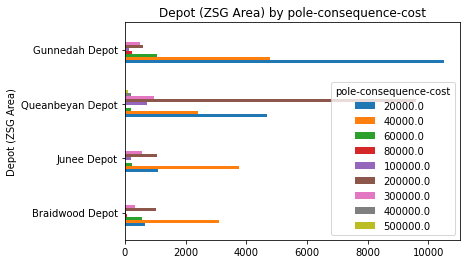

In [61]:
index = agg_cols[0]
columns = sens_var
idx_sample = df_pop[index].sample(10).unique()[:4]

consequence = df_pop.pivot_table(index=index, columns= columns, values = 'asset_count', aggfunc=sum).fillna(0).astype(int)
consequence.loc[idx_sample].plot(kind='barh', title=f'{index} by {columns}');

In [62]:
#Combine the two files together
df_result = pd.merge(df_pop, df_total, on=sens_var)

# Calculte the value lost across the population
df_result['value_lost_pop'] = df_result['value_lost'] * df_result['asset_count']

# Sense check tat the results are ok
by = agg_cols + [sens_var] + [x_var]
df_result.groupby(by)['value_lost', 'value_lost_pop',].sum().reset_index()

,Depot (ZSG Area),pole-consequence-cost,pole-task_group_name-groundline-t_interval,value_lost,value_lost_pop
0,Albury Depot,20000.0,2.0,17.970625,134887.509628
1,Albury Depot,20000.0,3.0,12.764839,95812.881235
2,Albury Depot,20000.0,4.0,4.462572,33496.065453
3,Albury Depot,20000.0,5.0,2.447194,18368.635845
4,Albury Depot,20000.0,6.0,0.000000,0.000000
...,...,...,...,...,...
4489,[ Deleted Assets ],300000.0,3.0,155.519919,155.519919
4490,[ Deleted Assets ],300000.0,4.0,91.813614,91.813614
4491,[ Deleted Assets ],300000.0,5.0,44.390758,44.390758
4492,[ Deleted Assets ],300000.0,6.0,25.046802,25.046802


In [63]:
# Caculate the value lost across ignoring sub populations
df_all = df_result.groupby(by=x_var).sum()[['value_lost', 'value_lost_pop']].reset_index()
df_all[agg_cols] = "all"

# Calculate the value lost within sub populations
by = [x_var] + agg_cols
df_agg = df_result.groupby(by=by).sum()[['value_lost', 'value_lost_pop']].reset_index()

# Combine them together
df_all = df_all.append(df_agg)

In [64]:
# Plot the results
make_value_lost_fig(df_all, x_axis=x_var, y_axis='value_lost_pop', legend =agg_cols[0])

## Insights
Insights should be run with an emphasis on accuracy rather than simulation time and have each been set up with high iteration counts

### Impact of improving inspection effectiveness

In [ ]:
var_id = 'pole-task_group_name-inspection_groundline-p_effective'
comp.expected_sensitivity(var_id = var_id, lower = 0.1, upper = 1, step_size= 0.1, n_iterations=1000, t_end=100)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

### Min effectiveness for Pole Saver Rod

In [ ]:
# Turn on Pole Saver Rod
comp.fm['fungal decay | internal'].tasks['pole_saver_rod'].active = True

# Run simulation
var_id = 'pole-task_group_name-inspection_groundline-p_effective'
comp.expected_sensitivity(var_id = var_id, lower = 0.1, upper = 1, step_size= 0.1, n_iterations=1000, t_end=100)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

# Turn off Pole Saver Rod
comp.fm['fungal decay | internal'].tasks['pole_saver_rod'].active = False

## Long run simulation - Single model
Run a long simulation to repeat the process above for the key outputs without the interim steps

In [79]:
t_end = 100
n_iterations = 100
model_units = 'years'

var_id = 'pole-task_group_name-groundline-t_interval'
lower = 1
upper = 10 
step_size = 1

comp.expected_sensitivity(var_id, lower, upper, step_size, n_iterations, t_end)
clear_output(al
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

SyntaxError: invalid syntax (<ipython-input-79-deac056cda84>, line 12)

In [77]:
t_end = 1200
n_iterations = 1000
model_units = 'months'

var_id = 'pole-task_group_name-groundline-t_interval'
lower = 6
upper = 120 
step_size = 6

comp.expected_sensitivity(var_id, lower, upper, step_size, n_iterations, t_end)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

## Long run simulation 
Run a long simulation to repeat the process above for the key outputs without the interim steps

In [73]:
# Set the parameters
t_end = 100 * 12
n_iterations = 100
model_units = 'months'
sens_vars = {
    'pole-consequence-cost': np.arange(0, 2e6, 2e5),
    'pole-task_group_name-groundline-t_interval': np.arange(0, 120, 3)
}

x_var = 'pole-task_group_name-groundline-t_interval'
y_var = 'pole-consequence-cost'
z_var = 'value_lost'

pop_var = 'Total Consequence $'

window=5

In [74]:
# Run the simulation
comp.units = model_units

df_sens_chain = comp.sensitivty_chain(sens_vars, t_end=t_end, n_iterations=n_iterations)

df_rolling = rolling_mean(df_sens_chain, window=window)

df_total = calc_value_lost(df=df_rolling, x_var='pole-task_group_name-groundline-t_interval', y_var='pole-consequence-cost')

In [57]:
df_sens_var = pd.DataFrame(sens_vars[y_var], columns= [y_var])

# Fill with average val
df_cons[pop_var] = df_cons[pop_var].fillna(df_cons[pop_var].mean())

# Match to the closest value from the model
df = pd.merge_asof(
    df_cons.sort_values(pop_var),
    df_sens_var,
    left_on = pop_var,
    right_on = y_var,
    direction = 'forward'
)

df_plot = pd.merge(df, df_total.reset_index(), on=y_var).groupby(by=x_var).sum().reset_index()
#y= ['list(set(df_plot) - set([sens_var, uid_col]))']
y = ['quantity_annual', 'cost_annual', 'value_lost']

px.line(df_plot, x=x_var, y=y)

MemoryError: Unable to allocate 385. MiB for an array with shape (50403348,) and data type int64

In [36]:
depots = ['Young Depot', 'Temora Depot', 'Yass Depot', 'Young Depot', 'Bathurst Depot']

In [66]:
df_cons['Total Consequence $'].mean()

80721.75110819022

In [75]:
df_cons['Total Consequence $'].median()

22927.130721795296